In [ ]:
import os
import glob
import pickle
import time
import json

os.environ["PRIVBAYES_BIN"] = "./ydnpd/harness/synthesis/privbayes/mac_bin"

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display, Markdown
import seaborn as sns


import ydnpd
from additional import ADDITIONAL_EXPERIMENTS, ADDITIONAL_PATH
from ydnpd import EVALUATION_METRICS, ALL_EXPERIMENTS, Experiments

ADDITIONAL_DATASETS = sum(list(ADDITIONAL_EXPERIMENTS.values()), [])

with open("./results/harness.pkl", "rb") as f:
    utility_tasks_results = pickle.load(f)

with open("./results/harness-epsilon-2.pkl", "rb") as f:
    more_utility_tasks_results = pickle.load(f)

# merge the two dicts
utility_tasks_results = utility_tasks_results + more_utility_tasks_results

for x in utility_tasks_results:
    if type(x["evaluation"]["error_rate_diff"]) == list:
        assert len(x["evaluation"]["error_rate_diff"]) == 1
        x["evaluation"]["error_rate_diff"] = x["evaluation"]["error_rate_diff"][0]
# keep only results where dataset name contains "acs"
# acs_results = [x for x in utility_tasks_results if "acs" in x["dataset_name"].lower()]
utility_tasks_results = utility_tasks_results
# also get rid of results where synth is gem
utility_tasks_results = [x for x in utility_tasks_results if x["synth_name"] != "gem"]
# check which metrics are nan for which datasets
# NOTE: there are some datasets for which there are more nans. we will just not include...
missing_metrics = {}
for x in utility_tasks_results:
    for metric in EVALUATION_METRICS:
        if np.isnan(x["evaluation"][metric]):
            missing_metrics[x["dataset_name"]] = missing_metrics.get(x["dataset_name"], []) + [metric]
all_results = utility_tasks_results.copy()

reference_data_mapping = {
    "acs": "acs/national",
    "edad": "edad/2023",
    "we": "we/2023",
}

METRIC_DIRECTION = {
    "total_variation_distance": "closer_to_zero_is_better",
    "pearson_corr_max_abs_diff": "closer_to_zero_is_better",
    "pearson_corr_avg_abs_diff": "closer_to_zero_is_better",
    "cramer_v_corr_max_abs_diff": "closer_to_zero_is_better",
    "cramer_v_corr_avg_abs_diff": "closer_to_zero_is_better",
    "marginals_3_max_abs_diff_error": "closer_to_zero_is_better",
    "marginals_3_avg_abs_diff_error": "closer_to_zero_is_better",
    "thresholded_marginals_3_max_abs_diff_error": "closer_to_zero_is_better",
    "thresholded_marginals_3_avg_abs_diff_error": "closer_to_zero_is_better",
    "error_rate_diff": "closer_to_zero_is_better",
    "aoc_diff": "closer_to_zero_is_better",
}

CORRELATION_METRICS = [
    "total_variation_distance",
    "pearson_corr_max_abs_diff",
    "pearson_corr_avg_abs_diff",
    "cramer_v_corr_max_abs_diff",
    "cramer_v_corr_avg_abs_diff",
]
MARGINALS_METRICS = [
    "marginals_3_max_abs_diff_error",
    "marginals_3_avg_abs_diff_error",
    "thresholded_marginals_3_max_abs_diff_error",
    "thresholded_marginals_3_avg_abs_diff_error",
]
CLASSIFICATION_METRICS = [
    "error_rate_diff",
    "aoc_diff",
]

df = pd.DataFrame(all_results)

df_evaluation = pd.json_normalize(df["evaluation"])

def dict_to_sorted_json_str(d):
    return str(json.dumps(d, sort_keys=True)) # str(

df["hparams_str"] = df["hparams"].apply(dict_to_sorted_json_str)

df_combined = pd.concat(
    [df.drop(columns=["hparams", "evaluation"]),
     df_evaluation],
    axis=1
)

# group by hparams_str, take the mean
df_combined = df_combined[['hparams_str', 'synth_name', 'epsilon', 'dataset_name'] + list(METRIC_DIRECTION.keys())].groupby(['hparams_str', 'synth_name', 'epsilon', 'dataset_name']).mean().reset_index()

def get_reference_dataset_name(ds_name):
    if ds_name.startswith("acs/"):
        return reference_data_mapping["acs"]
    elif ds_name.startswith("edad/"):
        return reference_data_mapping["edad"]
    elif ds_name.startswith("we/"):
        return reference_data_mapping["we"]
    else:
        raise ValueError(f"Unknown dataset name: {ds_name}")

df_combined["reference_dataset_name"] = df_combined["dataset_name"].apply(get_reference_dataset_name)

def find_best_performance_rows(subdf, metric):
    direction = METRIC_DIRECTION[metric]
    if direction == "closer_to_zero_is_better":
        best_val = subdf[metric].abs().min()
        best_hparams_str = subdf[subdf[metric].abs() == best_val]["hparams_str"].iloc[0]
        return subdf[subdf[metric].abs() == best_val], best_hparams_str
    else:
        raise ValueError(f"everything is closer_to_zero_is_better now")
    
rows_for_report = []

# skipped tracker
skipped = {}
group_cols = ["synth_name", "epsilon", "reference_dataset_name"]
for (synth_name, epsilon, reference_dataset_name), group_df in df_combined.groupby(group_cols):
    # identify the reference dataset within this group
    ref_df = group_df[group_df["dataset_name"] == reference_dataset_name]
    if ref_df.empty:
        continue

    # find the 'true best performance' for each metric in that reference subset
    true_best_performance = {}
    for metric in METRIC_DIRECTION.keys():
        best_rows, best_hparams = find_best_performance_rows(ref_df, metric)
        # just pick the first row in case of tie
        best_row = best_rows.iloc[0]
        true_best_val = np.abs(best_row[metric])
        true_best_performance[metric] = (true_best_val, best_row, best_hparams)

    # for each dataset in the group, figure out which hyperparams you'd pick
    for ds_name, ds_group_df in group_df.groupby("dataset_name"):

        # then do that for each metric (or each metric block)
        for metric in METRIC_DIRECTION.keys():
            try:
                best_ds_rows, _ = find_best_performance_rows(ds_group_df, metric)
                chosen_row = best_ds_rows.iloc[0]  # pick first in tie
                chosen_hparams_str = chosen_row["hparams_str"]

                # now we see if that same hparams_str is present in the reference df
                ref_match = ref_df[ref_df["hparams_str"] == chosen_hparams_str]
                if ref_match.empty:
                    # means reference never had that exact set of hyperparams
                    raise ValueError(f"whoops")

                # how does it perform on the reference dataset?
                row_in_ref = ref_match.iloc[0]
                perf_on_ref = np.abs(row_in_ref[metric])

                # get the "true best" value for that metric
                (true_best_val, _, best_hparams) = true_best_performance[metric]

                # define percent_degradation = (candidate - best) / abs(best), if best != 0, else 0
                if true_best_val == 0:
                    pct_degradation = 0
                else:
                    pct_degradation = (perf_on_ref - true_best_val) / abs(true_best_val)

                # store in our report
                rows_for_report.append({
                    "synth_name": synth_name,
                    "epsilon": epsilon,
                    "dataset_name": ds_name,
                    "metric": metric,
                    "chosen_hparams_str": chosen_hparams_str,
                    "chosen_val_on_dataset": np.abs(chosen_row[metric]),
                    "perf_on_reference": perf_on_ref,
                    "true_best_on_reference": true_best_val,
                    "pct_degradation_on_ref": pct_degradation,
                    "best_hparams": best_hparams,
                    "reference_dataset_name": reference_dataset_name,
                })
            except Exception as e:
                print(f"Skipping {synth_name}, {epsilon}, {ds_name}, {metric}: {e}")
                if (synth_name, epsilon, ds_name, metric) not in skipped:
                    skipped[(synth_name, epsilon, ds_name, metric)] = 0
                skipped[(synth_name, epsilon, ds_name, metric)] += 1


report_df = pd.DataFrame(rows_for_report)

METRIC_GROUPS = {
    "correlation_metrics": [
        "total_variation_distance",
        "pearson_corr_max_abs_diff",
        "pearson_corr_avg_abs_diff",
        "cramer_v_corr_max_abs_diff",
        "cramer_v_corr_avg_abs_diff",
    ],
    "marginals_metrics": [
        "marginals_3_max_abs_diff_error",
        "marginals_3_avg_abs_diff_error",
        "thresholded_marginals_3_max_abs_diff_error",
        "thresholded_marginals_3_avg_abs_diff_error",
    ],
    "classification_metrics": [
        "error_rate_diff",
        "aoc_diff",
    ],
}

# reverse mapping, metric -> group
metric_to_group = {}
for group, metrics in METRIC_GROUPS.items():
    for metric in metrics:
        metric_to_group[metric] = group

# metric_group to column to report_df
report_df['metric_group'] = report_df['metric'].map(metric_to_group)


/Users/lucasrosenblatt/opt/miniconda3/envs/fairly_uncertain/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-30 01:43:16,052	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Skipping aim_jax, 1, edad/gen-llama-MIX-MAX, error_rate_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 1, edad/gen-llama-MIX-MAX, aoc_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 1, edad/gen-llama-MIX-UNIF, error_rate_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 1, edad/gen-llama-MIX-UNIF, aoc_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 2, edad/gen-llama-MIX-MAX, error_rate_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 2, edad/gen-llama-MIX-MAX, aoc_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 2, edad/gen-llama-MIX-UNIF, error_rate_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 2, edad/gen-llama-MIX-UNIF, aoc_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 4, edad/gen-llama-MIX-MAX, error_rate_diff: single positional indexer is out-of-bounds
Skipping aim_jax, 4, edad/gen-llama-MIX-MAX, aoc_diff: single positional indexe

In [2]:
import pandas as pd
import numpy as np

epsilons = [1, 4, 8, 16]

all_distance_dfs = []
normalized_comparison = True
for synth_method in ['privbayes', 'aim_jax']:
    print()
    print(f"synthesizer: {synth_method}")

    filtered_df = report_df[
        (report_df['synth_name'] == synth_method) &
        (report_df['epsilon'].isin(epsilons))
    ]

    aggregated_df = filtered_df.groupby(['dataset_name', 'epsilon', 'reference_dataset_name'])['chosen_val_on_dataset'].mean().reset_index()
    for ref_ds_name in reference_data_mapping.values():
        print(f'dataset_name: {ref_ds_name}')
        # agg chosen_val_on_dataset to take the mean across all metrics for each dataset_name, epsilon
        ref_agged_df = aggregated_df[aggregated_df['reference_dataset_name'] == ref_ds_name]
        
        # take epsilons as columns and dataset_names as rows
        pivot_df = ref_agged_df.pivot(index='dataset_name', columns='epsilon', values='chosen_val_on_dataset')

        # drop datasets that do not have all epsilon values (if any), not fair comparison
        pivot_df = pivot_df.dropna()

        # optionally normalize the values so that they're all in the range [0, 1]
        # NOTE: this way, its a relative comparison, so you choose the epsilon value
        # based on a leveling out in performance

        # NOTE: NORMALIZE BASED ON PERCENT DIFFERENCE FROM THE REFERENCE DATASET
        if normalized_comparison:
            normalized_df = pivot_df.copy()
            for dataset in normalized_df.index:
                row = normalized_df.loc[dataset]
                min_val = row.min()
                max_val = row.max()
                if max_val - min_val != 0:
                    normalized_df.loc[dataset] = (row - min_val) / (max_val - min_val)
                else:
                    normalized_df.loc[dataset] = 0
        else:
            normalized_df = pivot_df

        if ref_ds_name not in normalized_df.index:
            raise ValueError(f"ref dataset {ref_ds_name} not present in the data")

        reference_vector = normalized_df.loc[ref_ds_name].values

        # we'll do both L1 and L2 distance between the vectors 
        def compute_distances(row, ref_vector):
            l1 = np.sum(np.abs(row - ref_vector))
            l2 = np.sqrt(np.sum((row - ref_vector) ** 2))
            return pd.Series({'L1_distance': l1, 'L2_distance': l2})

        distance_df = normalized_df.apply(lambda row: compute_distances(row.values, reference_vector), axis=1)

        distance_df = distance_df.reset_index()

        distance_df_sorted = distance_df.sort_values(['L2_distance'])

        # add columns for the reference dataset and synth
        distance_df_sorted['reference_dataset_name'] = ref_ds_name
        distance_df_sorted['synth_name'] = synth_method

        print("method by method performance compared to reference dataset")
        display(distance_df_sorted)

        all_distance_dfs.append(distance_df_sorted)

all_distance_df = pd.concat(all_distance_dfs)


synthesizer: privbayes
dataset_name: acs/national
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
15,acs/national,0.000000,0.000000,acs/national,privbayes
12,acs/gen-llama-MIX-MAX,0.015951,0.012837,acs/national,privbayes
0,acs/arbitrary,0.049257,0.036993,acs/national,privbayes
7,acs/gen-MIX-UNIF,0.093444,0.066086,acs/national,privbayes
14,acs/massachusetts_upsampled,0.099566,0.070775,acs/national,privbayes
6,acs/gen-MIX-MAX,0.093979,0.077925,acs/national,privbayes
3,acs/csv-claude,0.107524,0.087596,acs/national,privbayes
13,acs/gen-llama-MIX-UNIF,0.097717,0.088674,acs/national,privbayes
18,acs/sdscm-olmo-1b-hf,0.148188,0.116464,acs/national,privbayes
8,acs/gen-claude-MIX-MAX,0.181016,0.132624,acs/national,privbayes


dataset_name: edad/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,edad/2023,0.000000,0.000000,edad/2023,privbayes
17,edad/sdscm-llama-3-8b,0.040662,0.036022,edad/2023,privbayes
12,edad/gen-gpt-MIX-MAX,0.045974,0.044183,edad/2023,privbayes
18,edad/sdscm-olmo-1b-hf,0.076670,0.062503,edad/2023,privbayes
13,edad/gen-gpt-MIX-UNIF,0.101186,0.071573,edad/2023,privbayes
6,edad/csv-gpt,0.119657,0.087593,edad/2023,privbayes
8,edad/gen-MIX-MAX,0.130092,0.096201,edad/2023,privbayes
11,edad/gen-claude-MIX-UNIF,0.103577,0.096460,edad/2023,privbayes
0,edad/2020,0.140893,0.103869,edad/2023,privbayes
7,edad/csv-llama,0.146915,0.128002,edad/2023,privbayes


dataset_name: we/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,we/2023,0.000000,0.000000,we/2023,privbayes
15,we/gen-llama-MIX-UNIF,0.082560,0.071418,we/2023,privbayes
16,we/sdscm-gpt2,0.091419,0.075910,we/2023,privbayes
9,we/gen-MIX-UNIF,0.100137,0.082420,we/2023,privbayes
8,we/gen-MIX-MAX,0.110295,0.082522,we/2023,privbayes
14,we/gen-llama-MIX-MAX,0.120853,0.087190,we/2023,privbayes
12,we/gen-gpt-MIX-MAX,0.088929,0.087497,we/2023,privbayes
7,we/csv-llama,0.109984,0.105645,we/2023,privbayes
0,we/2018,0.146581,0.136119,we/2023,privbayes
2,we/arbitrary,0.181818,0.151893,we/2023,privbayes



synthesizer: aim_jax
dataset_name: acs/national
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
15,acs/national,0.000000,0.000000,acs/national,aim_jax
14,acs/massachusetts_upsampled,0.066825,0.063023,acs/national,aim_jax
0,acs/arbitrary,0.154630,0.117788,acs/national,aim_jax
2,acs/baseline_univariate,0.380325,0.276480,acs/national,aim_jax
17,acs/sdscm-llama-3-8b,0.446849,0.314983,acs/national,aim_jax
1,acs/baseline_domain,0.455265,0.330738,acs/national,aim_jax
5,acs/csv-llama,0.689858,0.479360,acs/national,aim_jax
18,acs/sdscm-olmo-1b-hf,0.809976,0.722284,acs/national,aim_jax
6,acs/gen-MIX-MAX,0.946763,0.797929,acs/national,aim_jax
7,acs/gen-MIX-UNIF,1.222751,0.867389,acs/national,aim_jax


dataset_name: edad/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,edad/2023,0.000000,0.000000,edad/2023,aim_jax
11,edad/gen-claude-MIX-UNIF,0.081823,0.058012,edad/2023,aim_jax
2,edad/arbitrary,0.085729,0.076673,edad/2023,aim_jax
0,edad/2020,0.103181,0.078147,edad/2023,aim_jax
9,edad/gen-MIX-UNIF,0.138225,0.106079,edad/2023,aim_jax
10,edad/gen-claude-MIX-MAX,0.131885,0.108142,edad/2023,aim_jax
3,edad/baseline_domain,0.174974,0.124257,edad/2023,aim_jax
4,edad/baseline_univariate,0.185966,0.131856,edad/2023,aim_jax
18,edad/sdscm-olmo-1b-hf,0.203922,0.136877,edad/2023,aim_jax
14,edad/gen-llama-MIX-MAX,0.186138,0.141644,edad/2023,aim_jax


dataset_name: we/2023
method by method performance compared to reference dataset


,dataset_name,L1_distance,L2_distance,reference_dataset_name,synth_name
1,we/2023,0.000000,0.000000,we/2023,aim_jax
16,we/sdscm-gpt2,0.160723,0.113785,we/2023,aim_jax
17,we/sdscm-llama-3-8b,0.181426,0.116034,we/2023,aim_jax
0,we/2018,0.159209,0.122591,we/2023,aim_jax
8,we/gen-MIX-MAX,0.260351,0.172035,we/2023,aim_jax
13,we/gen-gpt-MIX-UNIF,0.298020,0.173416,we/2023,aim_jax
4,we/baseline_univariate,0.320377,0.199653,we/2023,aim_jax
12,we/gen-gpt-MIX-MAX,0.335912,0.213604,we/2023,aim_jax
15,we/gen-llama-MIX-UNIF,0.345907,0.248193,we/2023,aim_jax
18,we/sdscm-olmo-1b-hf,0.396798,0.248781,we/2023,aim_jax


## Adding plotting for these results

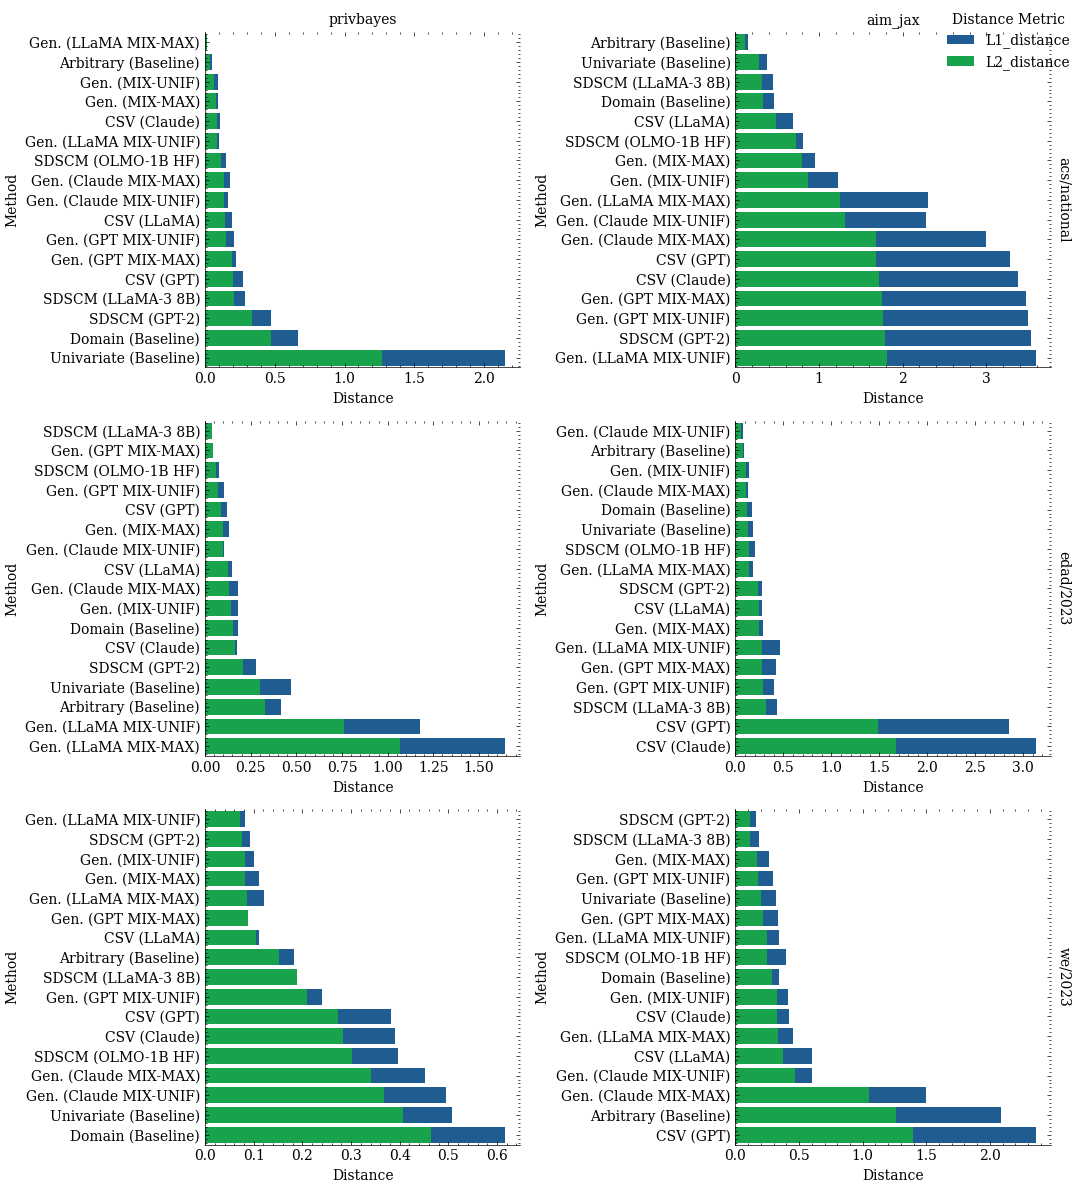

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


metric_group_map = {
    "correlation_metrics": "Correlation",
    "classification_metrics": "Classification",
    "marginals_metrics": "Marginals"
}

we_method_name_map = {
    "we/2018": "2018",
    "we/2023": "2023",
    "we/arbitrary": "Arbitrary (Baseline)",
    "we/baseline_domain": "Domain (Baseline)",
    "we/baseline_univariate": "Univariate (Baseline)",
    "we/csv-claude": "CSV (Claude)",
    "we/csv-gpt": "CSV (GPT)",
    "we/csv-llama": "CSV (LLaMA)",
    "we/gen-MIX-MAX": "Gen. (MIX-MAX)",
    "we/gen-MIX-UNIF": "Gen. (MIX-UNIF)",
    "we/gen-claude-MIX-MAX": "Gen. (Claude MIX-MAX)",
    "we/gen-claude-MIX-UNIF": "Gen. (Claude MIX-UNIF)",
    "we/gen-gpt-MIX-MAX": "Gen. (GPT MIX-MAX)",
    "we/gen-gpt-MIX-UNIF": "Gen. (GPT MIX-UNIF)",
    "we/gen-llama-MIX-MAX": "Gen. (LLaMA MIX-MAX)",
    "we/gen-llama-MIX-UNIF": "Gen. (LLaMA MIX-UNIF)",
    "we/sdscm-gpt2": "SDSCM (GPT-2)",
    "we/sdscm-llama-3-8b": "SDSCM (LLaMA-3 8B)",
    "we/sdscm-olmo-1b-hf": "SDSCM (OLMO-1B HF)"
}

acs_method_name_map = {
    "acs/arbitrary": "Arbitrary (Baseline)",
    "acs/baseline_domain": "Domain (Baseline)",
    "acs/baseline_univariate": "Univariate (Baseline)",
    "acs/csv-claude": "CSV (Claude)",
    "acs/csv-gpt": "CSV (GPT)",
    "acs/csv-llama": "CSV (LLaMA)",
    "acs/gen-MIX-MAX": "Gen. (MIX-MAX)",
    "acs/gen-MIX-UNIF": "Gen. (MIX-UNIF)",
    "acs/gen-claude-MIX-MAX": "Gen. (Claude MIX-MAX)",
    "acs/gen-claude-MIX-UNIF": "Gen. (Claude MIX-UNIF)",
    "acs/gen-gpt-MIX-MAX": "Gen. (GPT MIX-MAX)",
    "acs/gen-gpt-MIX-UNIF": "Gen. (GPT MIX-UNIF)",
    "acs/gen-llama-MIX-MAX": "Gen. (LLaMA MIX-MAX)",
    "acs/gen-llama-MIX-UNIF": "Gen. (LLaMA MIX-UNIF)",
    "acs/massachusetts_upsampled": "Massachusetts",
    "acs/national": "National",
    "acs/sdscm-gpt2": "SDSCM (GPT-2)",
    "acs/sdscm-llama-3-8b": "SDSCM (LLaMA-3 8B)",
    "acs/sdscm-olmo-1b-hf": "SDSCM (OLMO-1B HF)"
}

edad_method_name_map = {
    "edad/2020": "2020",
    "edad/2023": "2023",
    "edad/arbitrary": "Arbitrary (Baseline)",
    "edad/baseline_domain": "Domain (Baseline)",
    "edad/baseline_univariate": "Univariate (Baseline)",
    "edad/csv-claude": "CSV (Claude)",
    "edad/csv-gpt": "CSV (GPT)",
    "edad/csv-llama": "CSV (LLaMA)",
    "edad/gen-MIX-MAX": "Gen. (MIX-MAX)",
    "edad/gen-MIX-UNIF": "Gen. (MIX-UNIF)",
    "edad/gen-claude-MIX-MAX": "Gen. (Claude MIX-MAX)",
    "edad/gen-claude-MIX-UNIF": "Gen. (Claude MIX-UNIF)",
    "edad/gen-gpt-MIX-MAX": "Gen. (GPT MIX-MAX)",
    "edad/gen-gpt-MIX-UNIF": "Gen. (GPT MIX-UNIF)",
    "edad/gen-llama-MIX-MAX": "Gen. (LLaMA MIX-MAX)",
    "edad/gen-llama-MIX-UNIF": "Gen. (LLaMA MIX-UNIF)",
    "edad/sdscm-gpt2": "SDSCM (GPT-2)",
    "edad/sdscm-llama-3-8b": "SDSCM (LLaMA-3 8B)",
    "edad/sdscm-olmo-1b-hf": "SDSCM (OLMO-1B HF)"
}

rename_map = {
    "pct_degradation_on_ref": "% Degradation on Ref."
}

method_grouping = {
    "Arbitrary (Baseline)": "Baseline",
    "Domain (Baseline)": "Baseline",
    "Univariate (Baseline)": "Baseline",
    "CSV (Claude)": "CSV",
    "CSV (GPT)": "CSV",
    "CSV (LLaMA)":  "CSV",
    "Gen. (MIX-MAX)": "Gen",
    "Gen. (MIX-UNIF)":  "Gen",
    "Gen. (Claude MIX-MAX)": "Gen",
    "Gen. (Claude MIX-UNIF)": "Gen",
    "Gen. (GPT MIX-MAX)": "Gen",
    "Gen. (GPT MIX-UNIF)": "Gen",
    "Gen. (LLaMA MIX-MAX)": "Gen",
    "Gen. (LLaMA MIX-UNIF)": "Gen",
    "SDSCM (GPT-2)": "SDSCM",
    "SDSCM (LLaMA-3 8B)": "SDSCM",
    "SDSCM (OLMO-1B HF)":  "SDSCM",
}

grouping_colors = {
    # grey color
    "Baseline": "#808080",
    # green
    "CSV": "#008000",
    # orange
    "Gen": "#FFA500",
    # brown
    "SDSCM": "#A52A2A",
    # other should be magenta
    "Other": "#FF00FF"
}

def facet_plot_distances(all_distance_df, plot_name="facet_plot_distances"):
    with plt.style.context(['science']):
        plt.rc('text', usetex=False)

        all_name_map = {}
        all_name_map.update(we_method_name_map)
        all_name_map.update(acs_method_name_map)
        all_name_map.update(edad_method_name_map)

        df_long = pd.melt(
            all_distance_df,
            id_vars=["dataset_name", "reference_dataset_name", "synth_name"],
            value_vars=["L1_distance", "L2_distance"],
            var_name="distance_metric",
            value_name="distance_value",
        )

        df_long["dataset_name_label"] = (
            df_long["dataset_name"]
            .map(all_name_map)
            .fillna(df_long["dataset_name"]) 
        )

        g = sns.FacetGrid(
            df_long,
            row="reference_dataset_name",
            col="synth_name",
            hue="distance_metric",
            sharex=False,
            sharey=False,
            height=4,
            aspect=1.2,
            margin_titles=True,
        )

        g.map_dataframe(
            sns.barplot,
            x="distance_value",
            y="dataset_name_label",
            orient="h"
        )

        g.add_legend(title="Distance Metric", loc="upper right")
        g.set_titles(row_template="{row_name}", col_template="{col_name}")
        
        for ax in g.axes.flat:
            ax.set_xlabel("Distance")
            ax.set_ylabel("Method")

        plt.tight_layout()
        plt.savefig(f"plots/{plot_name}.pdf", bbox_inches="tight")
        plt.show()

facet_plot_distances(all_distance_df, plot_name="facet_plot_L1_L2_distances_priv_util")


### TODO: pareto frontier of these results

In [3]:
import numpy as np
import pandas as pd

reference_data_mapping = {
    "acs": "acs/national",
    "edad": "edad/2023",
    "we": "we/2023",
}

public_data_mapping = {
    "acs": "acs/massachusetts_upsampled",
    "edad": "edad/2020",
    "we": "we/2018",
}

all_distance_df = all_distance_df[~all_distance_df['dataset_name'].isin(reference_data_mapping.values())]
all_distance_df = all_distance_df[~all_distance_df['dataset_name'].isin(public_data_mapping.values())]

def is_pareto_efficient(costs):
    #find the Pareto-efficient points for array n_points, n_costs
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            # any point that is dominated by point i is not efficient
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True 
    return is_efficient

# pivot for L1 and L2 for each reference dataset
pivot_l1 = all_distance_df.pivot_table(
    index=['synth_name', 'dataset_name'],
    columns='reference_dataset_name',
    values='L1_distance'
).reset_index()

pivot_l2 = all_distance_df.pivot_table(
    index=['synth_name', 'dataset_name'],
    columns='reference_dataset_name',
    values='L2_distance'
).reset_index()

# for each pivot, for each dataset_name, remove text before "/". this will lead to duplicate dataset names.
pivot_l1['dataset_name'] = pivot_l1['dataset_name'].apply(lambda x: x.split("/")[1])
pivot_l2['dataset_name'] = pivot_l2['dataset_name'].apply(lambda x: x.split("/")[1])

# now, for each row, there will be 1 column with a value, and the rest will be NaN
# collapse so that each dataset name is only 1 row, with no NaNs
pivot_l1 = pivot_l1.groupby(['dataset_name','synth_name']).first().reset_index()
pivot_l2 = pivot_l2.groupby(['dataset_name','synth_name']).first().reset_index()

# rename columns of each so that end with _L1 and _L2
pivot_l1.columns = ['dataset_name', 'synth_name'] + [f"{ref}_L1" for ref in pivot_l1.columns if ref not in ['synth_name', 'dataset_name']]
pivot_l2.columns = ['dataset_name', 'synth_name'] + [f"{ref}_L2" for ref in pivot_l2.columns if ref not in ['synth_name', 'dataset_name']]

merged_pivot = pd.merge(pivot_l1, pivot_l2, on=['synth_name', 'dataset_name'])

In [4]:
synthesizers = merged_pivot['synth_name'].unique()

for synth in synthesizers:
    synth_df = merged_pivot[merged_pivot['synth_name'] == synth]
    print()
    print(f"pareto frontier for {synth}")
    
    distance_cols = [col for col in merged_pivot.columns if col.endswith('_L1') or col.endswith('_L2')]
    cost_matrix = synth_df[distance_cols].values
    
    pareto_mask = is_pareto_efficient(cost_matrix)
    pareto_front = synth_df[pareto_mask]
    
    display(pareto_front[['dataset_name'] + distance_cols])

    # also compute pareto frontier for average of L1 and average L2
    synth_df['avg_L1'] = synth_df[[col for col in synth_df.columns if col.endswith('_L1')]].mean(axis=1)
    synth_df['avg_L2'] = synth_df[[col for col in synth_df.columns if col.endswith('_L2')]].mean(axis=1)
    avg_cost_matrix = synth_df[['avg_L1', 'avg_L2']].values

    avg_pareto_mask = is_pareto_efficient(avg_cost_matrix)
    avg_pareto_front = synth_df[avg_pareto_mask]

    display(avg_pareto_front[['dataset_name', 'avg_L1', 'avg_L2']])



pareto frontier for aim_jax


,dataset_name,acs/national_L1,edad/2023_L1,we/2023_L1,acs/national_L2,edad/2023_L2,we/2023_L2
0,arbitrary,0.154630,0.085729,2.089599,0.117788,0.076673,1.261334
2,baseline_domain,0.455265,0.174974,0.340492,0.330738,0.124257,0.283848
4,baseline_univariate,0.380325,0.185966,0.320377,0.276480,0.131856,0.199653
12,gen-MIX-MAX,0.946763,0.290966,0.260351,0.797929,0.249259,0.172035
14,gen-MIX-UNIF,1.222751,0.138225,0.414205,0.867389,0.106079,0.324127
18,gen-claude-MIX-UNIF,2.272553,0.081823,0.602486,1.310591,0.058012,0.471635
28,sdscm-gpt2,3.535382,0.272824,0.160723,1.783427,0.229813,0.113785
30,sdscm-llama-3-8b,0.446849,0.430812,0.181426,0.314983,0.320728,0.116034


/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_4957/868331188.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_df['avg_L1'] = synth_df[[col for col in synth_df.columns if col.endswith('_L1')]].mean(axis=1)
/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_4957/868331188.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_df['avg_L2'] = synth_df[[col for col in synth_df.columns if col.endswith('_L2')]].mean(axis=1)


,dataset_name,avg_L1,avg_L2
4,baseline_univariate,0.295556,0.202663



pareto frontier for privbayes


,dataset_name,acs/national_L1,edad/2023_L1,we/2023_L1,acs/national_L2,edad/2023_L2,we/2023_L2
1,arbitrary,0.049257,0.417007,0.181818,0.036993,0.326228,0.151893
11,csv-llama,0.196796,0.146915,0.109984,0.143595,0.128002,0.105645
13,gen-MIX-MAX,0.093979,0.130092,0.110295,0.077925,0.096201,0.082522
15,gen-MIX-UNIF,0.093444,0.180202,0.100137,0.066086,0.140279,0.082420
21,gen-gpt-MIX-MAX,0.221354,0.045974,0.088929,0.194604,0.044183,0.087497
23,gen-gpt-MIX-UNIF,0.210685,0.101186,0.241353,0.149133,0.071573,0.209620
25,gen-llama-MIX-MAX,0.015951,1.644731,0.120853,0.012837,1.067734,0.087190
27,gen-llama-MIX-UNIF,0.097717,1.178327,0.082560,0.088674,0.759052,0.071418
29,sdscm-gpt2,0.472508,0.277064,0.091419,0.335277,0.210166,0.075910
31,sdscm-llama-3-8b,0.287252,0.040662,0.189194,0.206214,0.036022,0.187975


/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_4957/868331188.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_df['avg_L1'] = synth_df[[col for col in synth_df.columns if col.endswith('_L1')]].mean(axis=1)
/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_4957/868331188.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synth_df['avg_L2'] = synth_df[[col for col in synth_df.columns if col.endswith('_L2')]].mean(axis=1)


,dataset_name,avg_L1,avg_L2
13,gen-MIX-MAX,0.111455,0.085549


In [6]:
from table_utils import create_latex_table_with_medals

create_latex_table_with_medals(pareto_front)

TypeError: 'NoneType' object is not callable